# **Анализ параметров, определяющих успешность игры**

## Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).   

**Вам нужно выявить определяющие успешность игры закономерности**. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же
2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Загрузка библиотек

In [1]:
# загрузим все нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np
import math
from scipy import stats as st
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
from scipy.stats import normaltest
import matplotlib.patches as mpatches
%matplotlib inline

sns.set_palette("muted")
sns.set_style("whitegrid")

import warnings
warnings.simplefilter('ignore')

## **Описание данных** 

Name — название игры  
Platform — платформа  
Year_of_Release — год выпуска  
Genre — жанр игры  
NA_sales — продажи в Северной Америке (миллионы проданных копий)  
EU_sales — продажи в Европе (миллионы проданных копий)  
JP_sales — продажи в Японии (миллионы проданных копий)  
Other_sales — продажи в других странах (миллионы проданных копий)  
Critic_Score — оценка критиков (максимум 100)  
User_Score — оценка пользователей (максимум 10)  
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


*Наблюдение_1*  
- первое что бросается в глаза - названия столбцов не в snake_register -> исправим  
- Year_of_Release - float нужно заменить на int  
- Critic_Score - float нужно заменить на int (после проверки, есть ли цифры после точки)  
- Выдим пропущенные значения в Critic_Score, User_Score	и Rating - изучим их дальше

In [3]:
# приведем имена столбцов к нижнему регисту 

df.columns = df.columns.str.lower()

In [4]:
# посмотрим на типы данных и количество непустых строчек

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


*Наблюдение_2*  
- количество строк в dataset - 16715 строк  
- увидили, что еще пропуски есть в Name, Year_of_Release, Genre  
- User_Score числовые значения, поэтому поменяем object -> float  


In [5]:
# описательная статистика

df.describe(include=[object])

,name,platform,genre,user_score,rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


*Наблюдение_3*  
- самая популярная игра: Need for Speed: Most Wanted  
- больше всего игр выпущено для PS2 (12.9% - 2161/16715)
- самый популярный жанр - Экшен  (20.2% - 3369/16713)
- самая частая оценка от пользователя - tbd "to be determined" (24.2% - 2424/10014). По моей практике, такое ставят, чтобы позже сделать. А значит, на данный момент это значение не определено. Посмотрим на стрчки с tbd поближе.
- наиболее частый рейтинг: E - Everyone (40.1% - 3990/9949). В интервале 1994–1998 (as K-A), 1998–present (as E)) (согласно https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board) 


In [6]:
# описательная статистика

df.describe(include=[float])

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


*Наблюдение_4*  
- статистика ведется от 1980 года по 2016  
- в среднем наибольшое количество игр покупают/продают в Северной Америке  
- в среднем, игра получает оценку критиков 69 очков. Максимум, что было за все время - 98 очков


### Действия с tbd значениями в user_score

In [7]:
# посмотрим на строчки, где user_score со значение tbd

df[df['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


*Наблюдение_5*  
- видим, что продаж в разных странах отностельно немного, а значит оценок пользователей может и не быть или их очень мало. Так как tbd обозначет неопредленность на данный момент, заменю эти значения на NaN

In [8]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN)

### Пустые значения в critic_score, user_score, rating

In [9]:
# выведем столбцы, где есть пропущенные значения 

for column in df.columns:
    if df[column].count() != df.shape[0]:
        print(f'В {column} пропущенных строк: {df.shape[0] - df[column].count()}, {round(((df[column].isnull().sum())/df.shape[0])*100, 2)}%')

В name пропущенных строк: 2, 0.01%
В year_of_release пропущенных строк: 269, 1.61%
В genre пропущенных строк: 2, 0.01%
В critic_score пропущенных строк: 8578, 51.32%
В user_score пропущенных строк: 9125, 54.59%
В rating пропущенных строк: 6766, 40.48%


*Наблюдение_6*  
- Процент пропущенных значения для critic_score (51.32%), user_score (54.59%) и rating (40.48%) довольно большой, изучим данные поближе.


In [10]:
# посмотрим на строчки, где critic_score is NaN

df[df['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


*Наблюдение_7*  
Из данных видно, что оценки критиков нет у игр, которые очень старые (от 1985 года) и у игр от 2000х годов, которые купили в малых количествах (меньше млн). Есть, правда, и игры от 2005 года выпуска с неплохими продажами, что не вписывается в общую картину. 

Судя по https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board - организация ESRB была сформирована только в 1994 году, а значит для игр, которые были выпущены до этого года, рейтинга скорее всего не будет.  
Так же, возможно, у некоторых игр нет рейтинга, так как спрос на эти игры низкий и оценивать их нет смысла. 

Плюс, не забываем, что "данные за 2016 год могут быть неполными". 

Еще я бы проверила, все ли строчки, где пропущена оценка критиков, пропущен рейтинг и оценка пользователей. Если такие строчки есть, то можно говорить о следующей связи: малоизветсная/старая игра -> нет оценки критиков -> нет оценки пользователей -> нет рейтинга

In [11]:
# посмотрим на строчки, где user_score is NaN, а critic_score не ноль

data_us_zero = df[df['user_score'].isna()]
data_us_zero.query('critic_score > 0').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
182,Tomb Raider II,PS,1997.0,Action,2.30,2.46,0.2,0.28,85.0,NaN,T
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,NaN,E10+
440,Need for Speed III: Hot Pursuit,PS,1998.0,Racing,2.14,0.86,0.0,0.13,88.0,NaN,E
637,Riven: The Sequel to Myst,PC,1997.0,Adventure,1.52,0.82,0.0,0.10,83.0,NaN,E
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,NaN,E


*Наблюдение_8*  
Так же видно, что оценки пользователей нет у малопопулярных игр.

In [12]:
# посмотрим какое минимальное значение у года, где user_score и  critic_score is NaN, а rating не ноль

data_nan = df[(df['critic_score'].isnull()) & (df['user_score'].isnull() & (df['rating'].isnull() == False))]
data_nan['year_of_release'].min()

1992.0

In [13]:
# проверим, какие есть рейтинги

df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

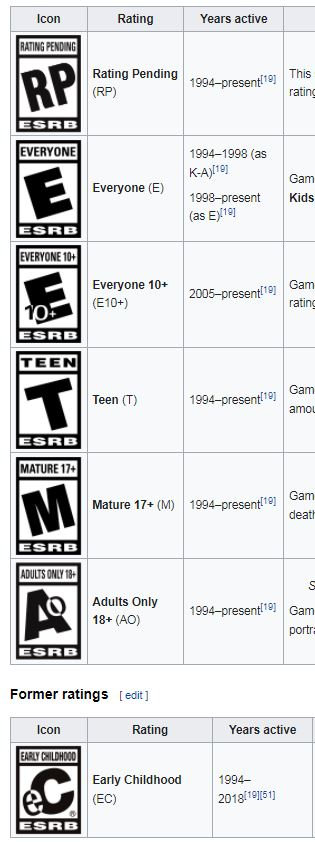

*Наблюдение_9*  
Все рейтинги соотвествуют названиям рейтингов ESRB.  
Потвержается теория о том, что до 1992 (~1994) года нет рейтинга от ESRB. А значит, можно изменить NaN.  
Так как у ESRB есть рейтинг RP (Rating Pending), который по сути тоже неопредеден, то пустые значения меняю на него.
Так же видим, что E и K-A это по сути один и тот же рейтинг, значит изменим K-A на E.

In [14]:
df.loc[df['rating'] == "K-A", 'rating'] = "E"

# check

df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

In [15]:
# Проверим, есть ли строки, где все данные пустые сразу в трех стобцах: critic_score, user_score, rating

df[(df['critic_score'].isnull()) & (df['user_score'].isnull()) & (df['rating'].isnull())].shape[0]

6667

*Наблюдение_10*  
Итого, такие строчки составляют ~73% (6667/9125) пропущенных значения в user_score и ~99% (6667/6766) в rating. Так же, стоит отметить, что в NaN значений столбца были добавлены 2424 строчки tbd -> 6667/(9125-2424) = 6667/6701 ~99.5%  Значит, для большиства, если нет оценки критика - нет и оценок пользователей и рейтинга.  

Заполнять значения медианой или средним нет смысла, так как даже в отдельных жанрах, игры могут быть с совершенно разной оценкой критиков и пользователей.  

Я бы заполнила нулем оба столбца user_score и critic_score, но сначала проверим, есть ли в них строчки с нулевой оценкой, чтобы не перемешать данные.

In [16]:
print(f"Строчки с 0 в critic_score: {df.query('critic_score == 0').shape[0]}")
print(f"Строчки с 0 в user_score: {df.query('user_score == 0').shape[0]}")

Строчки с 0 в critic_score: 0
Строчки с 0 в user_score: 0


In [17]:
# меняем пустые значения

list_columns = ['critic_score','user_score', 'rating']

for column in list_columns:
    if column == 'rating':
        df[column] = df[column].fillna("RP")  # rating pending
    else:
        df[column] = df[column].fillna(0)

# check

df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,0,RP
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


### Пустые значения в name и genre

In [18]:
# check

df.isna().sum()

name                 2
platform             0
year_of_release    269
genre                2
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
dtype: int64

In [19]:
# посмотрим на строки, где name пустой

df[df['name'].isnull()].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,0.0,0,RP
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,0.0,0,RP


*Наблюдение_11*  
Так как непонятно, что это за игры и значения всего два (0.01%), то можно смело удалить эти строчки.

In [20]:
df.dropna(axis=0, subset=['name'], inplace=True)

### Пустые значения в year_of_release

In [21]:
# check

df.isna().sum()

name                 0
platform             0
year_of_release    269
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
dtype: int64

In [22]:
# посмотрим на строки, где year_of_release is NaN

df[df['year_of_release'].isnull()].tail()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.0,0.0,0.0,43.0,0,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.0,0.0,0.0,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.0,0.0,0.0,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.0,0.0,0.0,0.0,0,RP
16522,Virtua Quest,GC,NaN,Role-Playing,0.01,0.0,0.0,0.0,55.0,5.5,T


*Наблюдение_12*  
Проверим, есть ли кросплотформенные игры, обычно они выходят в одно время

In [23]:
# возьмем PDC World Championship Darts 2008 как пример

df.query('name == "PDC World Championship Darts 2008"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6917,PDC World Championship Darts 2008,Wii,2008.0,Sports,0.02,0.21,0.0,0.01,51.0,5.4,E10+
15953,PDC World Championship Darts 2008,DS,NaN,Sports,0.01,0.00,0.0,0.00,0.0,0,RP
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.0,0.00,43.0,0,E10+


In [24]:
# кросплотформенные игры есть, тогда добавим годы, где можем, вместо NaN

df['year_of_release'] = df['year_of_release'].fillna(df.groupby('name')['year_of_release'].transform("median"))

In [25]:
# check

df.query('name == "PDC World Championship Darts 2008"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6917,PDC World Championship Darts 2008,Wii,2008.0,Sports,0.02,0.21,0.0,0.01,51.0,5.4,E10+
15953,PDC World Championship Darts 2008,DS,2008.0,Sports,0.01,0.00,0.0,0.00,0.0,0,RP
16373,PDC World Championship Darts 2008,PSP,2008.0,Sports,0.01,0.00,0.0,0.00,43.0,0,E10+


In [26]:
# check

for column in df.columns:
    if df[column].count() != df.shape[0]:
        print(f'В {column} пропущенных строк: {df.shape[0] - df[column].count()}, {round(((df[column].isnull().sum())/df.shape[0])*100, 2)}%')

В year_of_release пропущенных строк: 146, 0.87%


*Наблюдение_13*  
Так как пропущенных данных меньше 1% и данных не хватает для заполнения пропусков, я удалю эти значения, чтобы спокойно провести анали по очищенному dataset-у

In [27]:
# удалим пустые значения

df.dropna(axis=0, subset=['year_of_release'], inplace=True)

In [28]:
# проверим данные на явные дубликаты

print(f'Количество дубликатов {df.duplicated().sum()}')

Количество дубликатов 0


### Изменение типов данных

In [29]:
# check

df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

*Наблюдение_14*  
Меняем:  
year_of_release -> int  
critic_score -> int  
user_score -> float

In [30]:
# правим типы данных и check

list_columns = ['year_of_release', 'critic_score', 'user_score']

for column in list_columns:
    if column != 'user_score':
        df[column] = df[column].astype('int')
    else:
        df[column] = df[column].astype('float')

df.dtypes

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score         int64
user_score         float64
rating              object
dtype: object

### Продажи по всем регионам

In [31]:
# добавим новый столбец

df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Итоговый df

In [32]:
# посмотрим, как выглядит теперь dataframe

df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,RP,31.38


In [33]:
# cмотрим как изменился dataset для object

df.describe(include=[object])

,name,platform,genre,rating
count,16567,16567,16567,16567
unique,11426,31,12,7
top,Need for Speed: Most Wanted,PS2,Action,RP
freq,12,2140,3342,6701


*Наблюдение_15*  
- самая популярная игра: Need for Speed: Most Wanted (осталась как и была)
- больше всего игр выпущено для PS2 (как и прежде)
- самый популярный жанр - Экшен (как и прежде)
- наиболее частый рейтинг теперь RP (вместо Е).

In [34]:
# cмотрим как изменился dataset для int

df.describe(include=[int])

,year_of_release,critic_score
count,16567.000000,16567.000000
mean,2006.490252,33.627694
std,5.862680,35.829802
min,1980.000000,0.000000
25%,2003.000000,0.000000
50%,2007.000000,0.000000
75%,2010.000000,70.000000
max,2016.000000,98.000000


*Наблюдение_16*  
- статистика все также ведется от 1980 года по 2016
- в среднем, игра получает оценку критиков 34 балла (вместо 69 очков)

In [35]:
# cмотрим как изменился dataset для float

df.describe(include=[float])

,na_sales,eu_sales,jp_sales,other_sales,user_score,total_sales
count,16567.000000,16567.000000,16567.000000,16567.000000,16567.000000,16567.000000
mean,0.263975,0.145814,0.078020,0.047567,3.242754,0.535376
std,0.816474,0.505364,0.310068,0.187476,3.689388,1.554281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.000000,0.170000
75%,0.240000,0.110000,0.040000,0.030000,7.300000,0.470000
max,41.360000,28.960000,10.220000,10.570000,9.700000,82.540000


*Наблюдение_17*  
- в среднем наибольшое количество игр покупают/продают в Северной Америке (как и было прежде)
- теперь выдим, что в среднем пользователи ставят оценку 3,3 (что соотносится со средней оценкой критиков)
- в среднем, одна игра на одной платформе продается по всему миру в размере 535 тыс копий

### Вывод

- самая популярная игра: Need for Speed: Most Wanted  
- больше всего игр выпущено для PS2  
- самый популярный жанр - Экшен  
- наиболее частый рейтинг теперь RP  
- в среднем наибольшое количество игр покупают/продают в Северной Америке  
- в среднем, игра получает оценку критиков 34 балла   
- в среднем пользователи ставят оценку 3,3 (что соотносится со средней оценкой критиков)  
- в среднем, одна игра на одной платформе продается по всему миру в размере 535 тыс копий  

Мы получили чистый df, готовый к анализу.

## Исследовательский анализ данных

### Количество игр, выпущенных и проданных в разные годы

Важны ли данные за все периоды?

In [36]:
# сгруппируем данные по годам
# я хотела бы сразу посмотреть, как отличаются выпущенные vs проданные копии по годам

df_count_year = df.groupby('year_of_release')['name'].agg(['count'])
df_sum_year = df.groupby('year_of_release')['total_sales'].agg(['sum'])

In [37]:
# объеденим Series в df

df_years = pd.concat([df_count_year, df_sum_year ], axis=1).reset_index()
df_years.columns = ['year', 'release_copies', 'sales_copies']
df_years.sort_values(by='sales_copies', ascending=False).head()

,year,release_copies,sales_copies
28,2008,1441,681.24
29,2009,1430,659.51
27,2007,1202,606.16
30,2010,1269,594.66
26,2006,1019,523.40


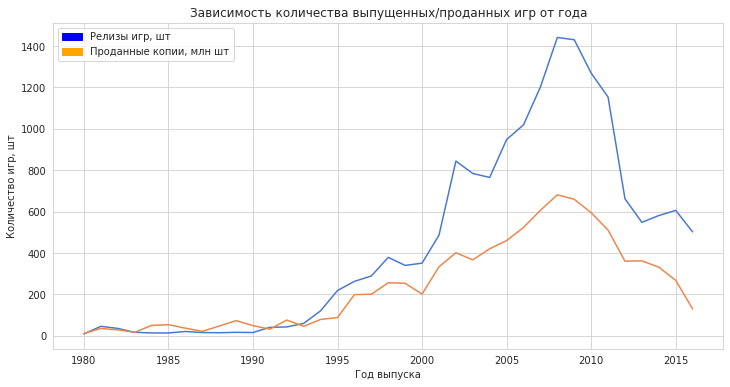

In [38]:
# построим линейный график

ax = df_years.plot.line(x='year', grid=True, figsize=(12,6))
blue_patch = mpatches.Patch(color='blue', label='Релизы игр, шт')
orange_patch = mpatches.Patch(color='orange', label='Проданные копии, млн шт')
ax.legend(handles=[blue_patch, orange_patch])
plt.title("Зависимость количества выпущенных/проданных игр от года")
plt.xlabel("Год выпуска")
plt.ylabel("Количество игр, шт")

plt.show()

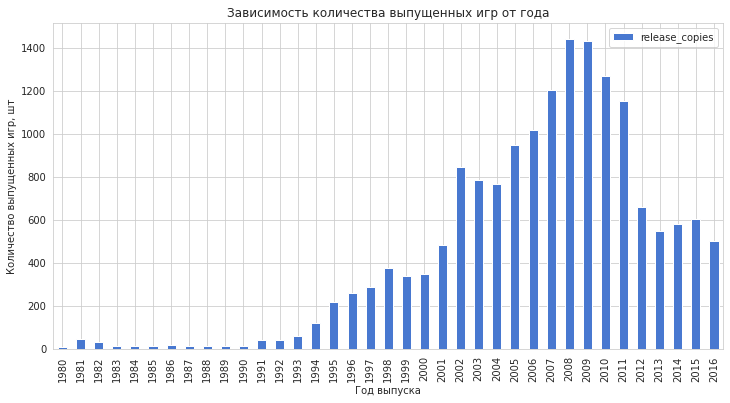

In [39]:
# построим bar plot для столбца release_copies, чтобы более детально увидеть распределение

df_years.plot(y='release_copies', x='year', kind = 'bar', figsize = (12,6), grid=True, rot=90, 
              xlabel="Год выпуска", 
              ylabel="Количество выпущенных игр, шт", 
              title="Зависимость количества выпущенных игр от года")

plt.show()

*Наблюдение_18*  
1) до 2008 года шел активный рост произвосдтва и продаж игр, что говорит о их популярности. После 2009 начался спад продаж и выпусков игр. Это может быть связано с ростом цифровизации: появлением смартфоном, планшетов (первый айфон был выпущен в июне 2007 года).  
2) Выдим резкий скачок в 2002 году и резкий спад в 2012

**Важны ли данные за все периоды?**  
> на данный момент я бы выделила три периода: рост с 1993 года по 2008 год, пик 2008-2009 года и спад

In [40]:
# создадим новый df, который включает строчки с годом 1993 и выше

df_1993 = df.query('year_of_release >= 1993')

### Анализ изменений продаж по платформам

Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [41]:
# сгруппируем данные по платформам

platf_sum_year = df_1993.groupby(['platform'])['total_sales'].agg(['sum']).reset_index()
platf_sum_year.columns = ['platform', 'sales_copies']
platf_sum_year.sort_values(by='sales_copies', ascending=False).head(10)

,platform,sales_copies
15,PS2,1247.16
27,X360,966.61
16,PS3,935.19
25,Wii,903.31
4,DS,804.26
14,PS,727.58
17,PS4,314.14
6,GBA,313.73
18,PSP,293.57
2,3DS,258.53


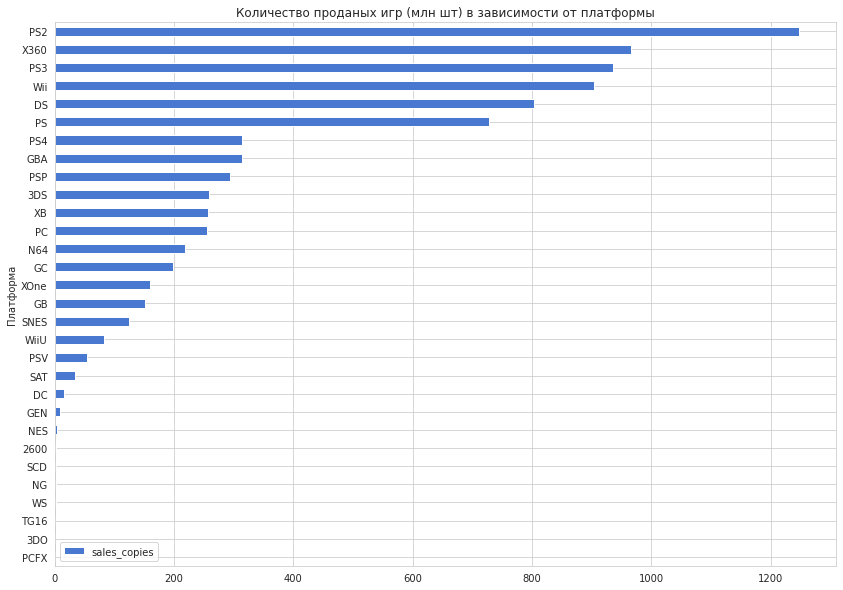

In [42]:
# построим bar plot 

platf_sum_year.sort_values(by='sales_copies', ascending=True).plot(y = 'sales_copies', x= 'platform', kind = 'barh', 
                                                                   figsize = (14,10), grid=True, rot=0, 
              xlabel="Платформа", 
              ylabel="Количество проданных копий, млн шт", 
              title="Количество проданых игр (млн шт) в зависимости от платформы")
plt.show()

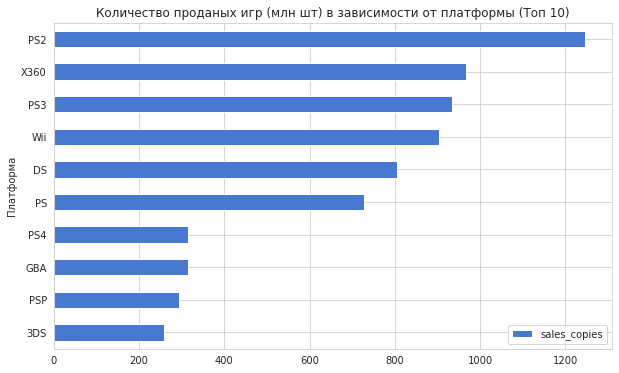

In [43]:
# построим bar plot для Top 10

platf_sum_year.sort_values(by='sales_copies', ascending=True).tail(10).plot(y = 'sales_copies', x= 'platform', kind = 'barh', 
                                                                            figsize = (10,6), grid=True, rot=0, 
              xlabel="Платформа", 
              ylabel="Количество проданных копий, млн шт", 
              title="Количество проданых игр (млн шт) в зависимости от платформы (Топ 10)")
plt.show()

*Наблюдение_19*  

Мы видим, что PS2 самая популярная.  
Думаю взять Топ 6, так как Топ 7 - 10 не сильно отличаются между собой, но сильно отличаются от Топ 1 - 6.  

**Выберите платформы с наибольшими суммарными продажами**  
> PS2, X360, PS3, Wii, DS, PS

In [44]:
# dataframe для Топ 6

list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
df_top_6 = df_1993.query('platform in list')

# check

df_top_6['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS2', 'PS'], dtype=object)

In [45]:
# сгруппируем данные по годам

platf_top_6_year = df_top_6.groupby(['year_of_release', 'platform'])['total_sales'].agg(['sum']).reset_index()
platf_top_6_year.columns = ['year', 'platform', 'sales_copies']
platf_top_6_year.head()

,year,platform,sales_copies
0,1994,PS,6.03
1,1995,PS,35.96
2,1996,PS,94.70
3,1997,PS,136.17
4,1998,PS,169.49


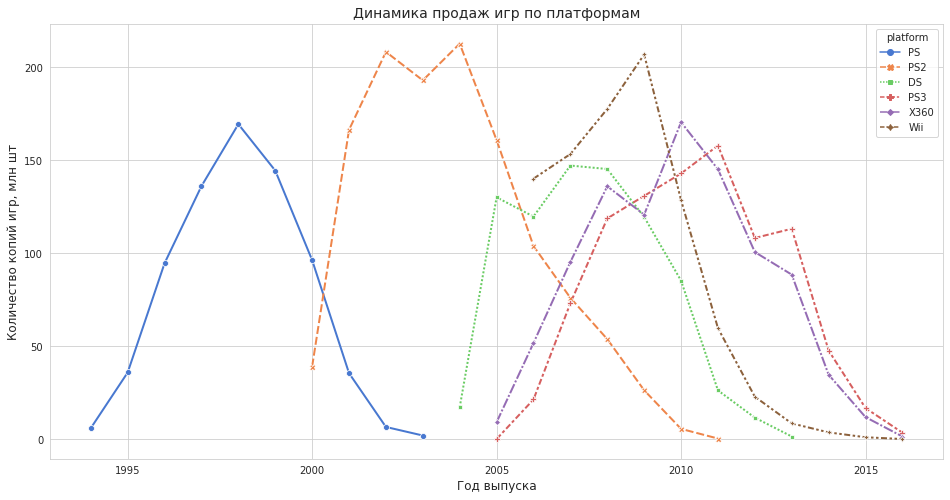

In [46]:
# построим линейные графики

plt.figure(figsize=(16,8))
sns.lineplot(data=platf_top_6_year, x="year", y='sales_copies', hue='platform', lw = 2, markers=True, markersize=6, 
             style ='platform')
plt.title("Динамика продаж игр по платформам", fontsize=14)
plt.xlabel("Год выпуска", fontsize=12)
plt.ylabel("Количество копий игр, млн шт", fontsize=12)
plt.show()

*Наблюдение_20*  

Самая древняя платформа - PS, 2 платформы вышли в одно время - X360 и PS3.  
Если посмотреть на пересечние линий для PS -> PS2 -> PS3, то мы видим, что PS2 вышло на 6 год существования PS, PS3 - на 5 год существования PS2. Так же, можно заметить, что выход новых консолей связан с прохождением пика продаж и последующим падением в течении двух лет для предидущих версий.

- PS2: 2000 - 2011 год -> 11 лет  
- X360: 2005 - 2016 год -> 9 лет  
- PS3: 2005 - 2016 год -> 9 лет   
- Wii: 2006 - 2016 год -> 10 лет  
- DS: 2004 - 2013 год -> 9 лет   
- PS: 1994 - 2003 год -> 9 лет  

В среднем платформы "живут" 10 лет, а новые платформы выходят спустя в среднем (судя, конечно, только по одной ОЧЕНЬ ПОПУЛЯРНОЙ платформе) 5 лет с момента выхода старой консоли (пик продаж ~ через 4 года + падение в течение года).  
Платформы устаревают за счет устаревания 'железа' (видеокарты например) и развития технологий. А то, что новые консоли выходят за несколько лет до устаревания существующих, по мне очень логичный шаг, т.к. люди еще могут наиграться в свои любимые игры и переход будет не таким резким.

Проверим гипотезу про выход новых консолей через 5 лет на примере еще одной популярной платформы - Xbox

In [47]:
# проверим какие консоли от Xbox представлены в dataset

df_1993['platform'].unique()

array(['Wii', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'GBA', 'PS4', '3DS',
       'N64', 'PS', 'SNES', 'XB', 'PC', 'PSP', 'XOne', 'WiiU', 'GC',
       '2600', 'DC', 'PSV', 'SAT', 'GEN', 'NES', 'SCD', 'WS', 'NG',
       'TG16', '3DO', 'PCFX'], dtype=object)

In [48]:
# сформируем df по Xbox

list = ['XB', 'X360', 'XOne']
df_xb = df_1993.query('platform in list')

# check

df_xb['platform'].unique()

array(['X360', 'XB', 'XOne'], dtype=object)

In [49]:
# сгруппируем данные по годам

platf_xb_year = df_xb.groupby(['year_of_release', 'platform'])['total_sales'].agg(['sum']).reset_index()
platf_xb_year.columns = ['year', 'platform', 'sales_copies']

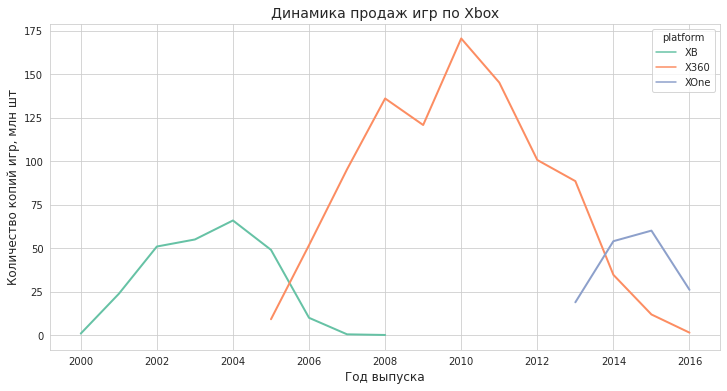

In [50]:
# построим линейные графики

plt.figure(figsize=(12,6))
sns.set_palette("Set2")
sns.lineplot(data=platf_xb_year, x="year", y='sales_copies', hue='platform', lw = 2)
plt.title("Динамика продаж игр по Xbox", fontsize=14)
plt.xlabel("Год выпуска", fontsize=12)
plt.ylabel("Количество копий игр, млн шт", fontsize=12)
plt.show()

*Наблюдение_21*  

Смотрим на пересечние линий для XB -> X360 -> XOne, то мы видим, что X360 вышло на 5 год существования XB, XOne - на 8 год существования X360. Судя по продажам, X360 очень популярная приставка в своей линейке, что возможно связано с тем, что XOne вышел спустя чуть больше времени. Здесь видим выход новых консолей также после пика продаж и последующим падением в течении 1 года (XB) и 3 лет (XOne). 

**За какой характерный срок появляются новые и исчезают старые платформы?**  
> новые консоли появляются спустя в среднем через 5 лет: по достижению пика (через 3-4 года) и последующему снижению продаж (в течении года- двух) предидущей версии      
> lifecircle консолей в среднем составляет 10 лет

### Выбор актуального периода

Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.   
Не учитывайте в работе данные за предыдущие годы.  

*Наблюдение_22*  

Первый фактор для выбора - продолжительность "жизни" консолей - 10 лет, значит для 2017 года погноз поможет построить данные с 2006 по 2016 год.  
Второй фактор: наиболее популярные на конец 2016 года консоли (PS3, X360) были выпущены в 2005 году.

Чтобы не потерять данные, я выбираю актуальным периодом ~~2005~~ 2010 - 2016 годы.

In [51]:
# создадим новый df
# df_2005 = df.query('year_of_release >= 2005')

df_2010 = df.query('year_of_release >= 2010')

# check

df_2010.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27


*Наблюдение_23*  

**Актуальный период:**  
> ~~2005 - 2016 год~~  
> 2010 - 2016 год

### Какие платформы лидируют по продажам, растут или падают? 
Выберите несколько потенциально прибыльных платформ.

In [52]:
# сгруппируем данные по платформам

platf_new_year = df_2010.groupby(['platform'])['total_sales'].agg(['sum']).reset_index()
platf_new_year.columns = ['platform', 'sales_copies']
platf_new_year = platf_new_year.sort_values(by='sales_copies', ascending=False).head(10)
platf_new_year

,platform,sales_copies
4,PS3,590.65
10,X360,553.30
5,PS4,314.14
0,3DS,258.51
8,Wii,225.06
11,XOne,159.32
1,DS,124.89
2,PC,124.82
9,WiiU,82.19
6,PSP,64.55


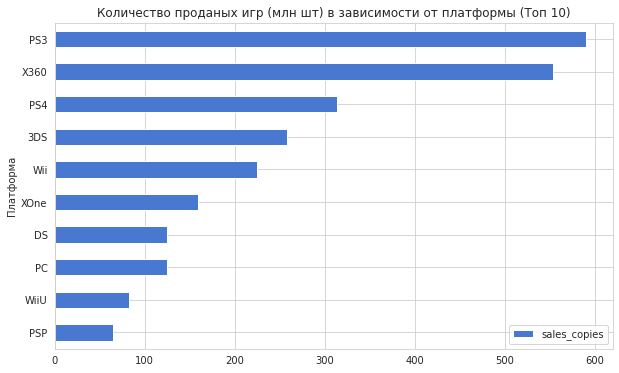

In [53]:
# построим bar plot для Top 10

sns.set_palette("muted")
platf_new_year.sort_values(by='sales_copies', ascending=True).tail(10).plot(y = 'sales_copies', x= 'platform', kind = 'barh', 
                                                                            figsize = (10,6), grid=True, rot=0, 
              xlabel="Платформа", 
              ylabel="Количество проданных копий, млн шт", 
              title="Количество проданых игр (млн шт) в зависимости от платформы (Топ 10)")
plt.show()

*Наблюдение_24*  

Наиболее популярные платформы в актуальный период: ~~X360, PS3, Wii~~ PS3, X360, PS4.  
~~Можно предположить, что следующии поколения этих платформ так жу будут популярны~~.  
Видим, что к 2016 году, PS4 уже догоняет по популярности предидущую версию консоли, и осталвляет позади новую консоль от XBox.

In [54]:
# dataframe для Топ 10

list = platf_new_year['platform'].unique()
platf_top_10 = df_2010.query('platform in list')

# check

platf_top_10['platform'].unique()

array(['X360', 'PS3', 'DS', 'PS4', '3DS', 'Wii', 'XOne', 'WiiU', 'PC',
       'PSP'], dtype=object)

In [55]:
# сгруппируем данные по годам

platf_top10_year = platf_top_10.groupby(['year_of_release', 'platform'])['total_sales'].agg(['sum']).reset_index()
platf_top10_year.columns = ['year', 'platform', 'sales_copies']
platf_top10_year.head()

,year,platform,sales_copies
0,2010,3DS,0.30
1,2010,DS,85.35
2,2010,PC,26.15
3,2010,PS3,142.96
4,2010,PSP,35.04


In [56]:
list = platf_new_year['platform'].unique()
list

array(['PS3', 'X360', 'PS4', '3DS', 'Wii', 'XOne', 'DS', 'PC', 'WiiU',
       'PSP'], dtype=object)

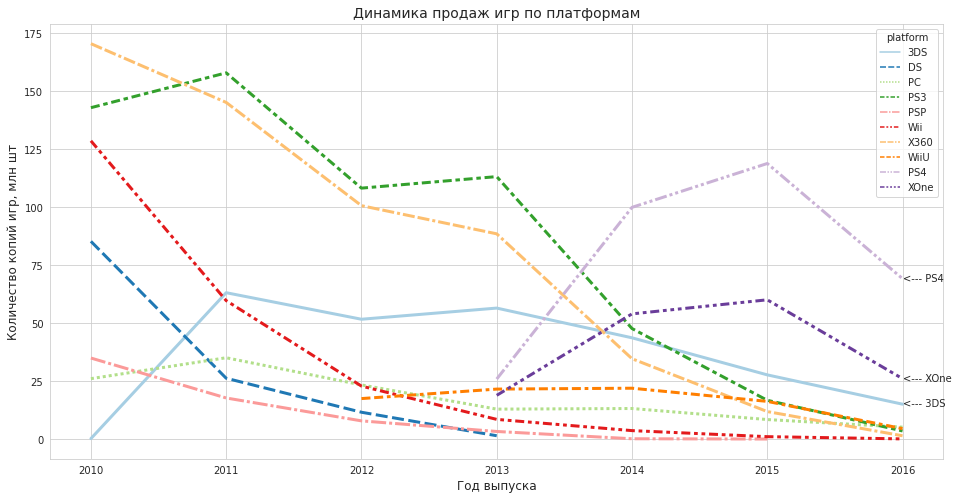

In [57]:
# построим линейные графики

plt.figure(figsize=(16,8))
sns.set_palette("Paired")
sns.lineplot(data=platf_top10_year, x="year", y='sales_copies', hue='platform', lw = 3, style ='platform')
plt.text(2016, 68, '<--- PS4')
plt.text(2016, 25, '<--- XOne')
plt.text(2016, 14, '<--- 3DS')
plt.title("Динамика продаж игр по платформам", fontsize=14)
plt.xlabel("Год выпуска", fontsize=12)
plt.ylabel("Количество копий игр, млн шт", fontsize=12)
plt.show()

*Наблюдение_25*  

На графике выделяются три платформы: PS4, XOne, 3DS. Видим, что у PS4 и XOne,пик продаж был в 2015 году, а значит можно ожидать выход новых консолей после 2017 года (спойлер: PS5 - 2020 год, Xbox Series X/S - 2019 год). Для Nintendo 3DS последний пик продаж был в 2013, а значит новая консоль ожидается после 2015 (спойлер: Nintendo Switch - 2017 год). Думаю, такие сдвиги связаны с популяростью консолей и выходом эксклюзивных игр на каждой из платформ.   
Так же видим, что продажи подают для всех платформ, что говорит либо об устраевании "железа", либо о угасанию игровой индустрии.  

Ко всему выше написанному, не забываем добавить "Данные за 2016 год могут быть неполными" 

**Какие платформы лидируют по продажам, растут или падают?**  
> Наиболее популярные платформы в актуальный период: ~~X360, PS3, Wii~~ PS3, X360, PS4.  
> Лидируют по продажам на конец 2016 года: PS4, XOne, 3DS ( следующии поколения X360, PS3, Wii). Заметим, что PlayStation перехватило лидерство у XBox.  
> Продажи падают.

### График «ящик с усами» по глобальным продажам игр в разбивке по платформам 

Опишите результат.

In [58]:
# взглянем на наш df

platf_top_10.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27


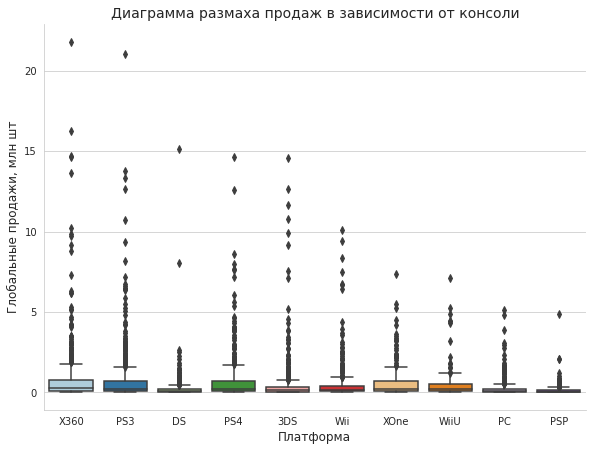

In [59]:
# строим box_and_whiskers diagram для топ 10 игр

plot = sns.catplot(x='platform', y="total_sales", kind="box", data=platf_top_10)
plot.fig.set_figwidth(8.5)
plot.fig.set_figheight(6)
plt.title('Диаграмма размаха продаж в зависимости от консоли', fontsize=14)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи, млн шт',fontsize=12)
plt.show()

In [60]:
# выбросов достаточно много и аномальные значения большие, поэтому нужно приблизить график и посмотрим, какая медиана и 
# среднее по платформам

stat_top10 = platf_top_10.groupby(['platform'])['total_sales'].agg(['mean', 'median']).reset_index()
stat_top10.columns = ['platform', 'mean', 'median']
stat_top10.sort_values(by='median', ascending=False)

,platform,mean,median
8,X360,0.800724,0.270
3,PS3,0.656278,0.230
7,WiiU,0.559116,0.220
9,XOne,0.645020,0.220
4,PS4,0.801378,0.200
6,Wii,0.494637,0.180
0,3DS,0.502938,0.125
1,DS,0.244403,0.100
2,PC,0.255779,0.080
5,PSP,0.128586,0.050


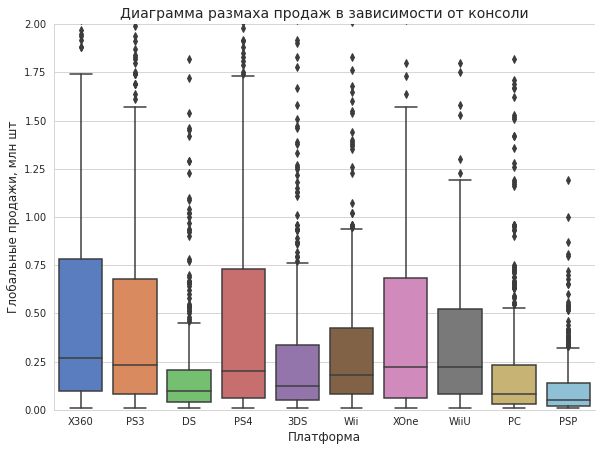

In [61]:
# приближаем график

sns.set_palette("muted")
plot = sns.catplot(x='platform', y="total_sales", kind="box", data=platf_top_10)
plot.fig.set_figwidth(8.5)
plot.fig.set_figheight(6)
plt.ylim(0,2)
plt.title('Диаграмма размаха продаж в зависимости от консоли', fontsize=14)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи, млн шт',fontsize=12)
plt.show()

*Наблюдение_26*  

Много продаж у X360, PS3, PS4, XOne. Медианные значения с минимальным отличием между PS3, WiiU и XOne. Среднее же похоже для PS4 и X360. Аномальные значения для PS4 и X360 начинаются в районе 1.75 млн шт.  
Самые низкие показатели у PSP и DS, что говорит о устаривании данных платформ, а значит и спроса на игры.
Так же видим, что количество продаж Nintendo WiiU отличается d 1.5 раза от PS/XBox.
Такое большое количество выбросов возможно связано с выходом крутых игр на каждой из платформ.

**Вывод**  
> Самое большое количество продаж у X360, PS3, PS4, XOne.   
> Медианы для всех платформ разные, хотя есть и близко стоящие друг к другу значения.  
> Самый маленький спрос на игры для ~~PC~~ PSP и DS.  

### Анализ влияния на продажи отзывов пользователей и критиков внутри одной популярной платформы 

Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

#### Анализ для PlayStation

In [62]:
# создаем df для ps3 и ps4

ps3_data = df_2010[(df_2010['platform'] == 'PS3') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]
ps4_data = df_2010[(df_2010['platform'] == 'PS4') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]

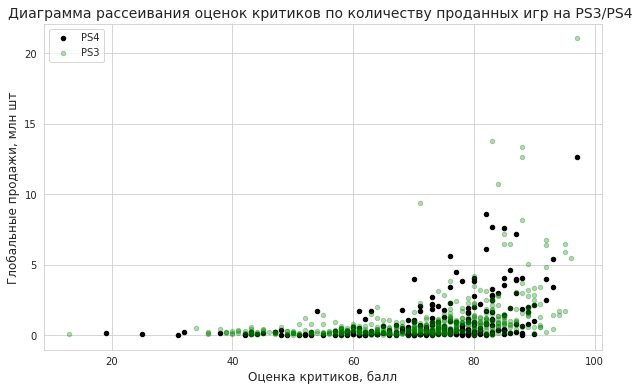

In [63]:
# строим точечную диаграмму для critic_score

ax = ps4_data.plot(kind='scatter', x='critic_score', y='total_sales', grid=True, color='black', label='PS4')
ps3_data.plot(kind='scatter', x='critic_score', y='total_sales', figsize=(10,6), grid=True, ax=ax, alpha=0.3, color='green', 
              label='PS3')
plt.title('Диаграмма рассеивания оценок критиков по количеству проданных игр на PS3/PS4 ', fontsize=14)
plt.xlabel('Оценка критиков, балл', fontsize=12)
plt.ylabel('Глобальные продажи, млн шт',fontsize=12)
plt.show()

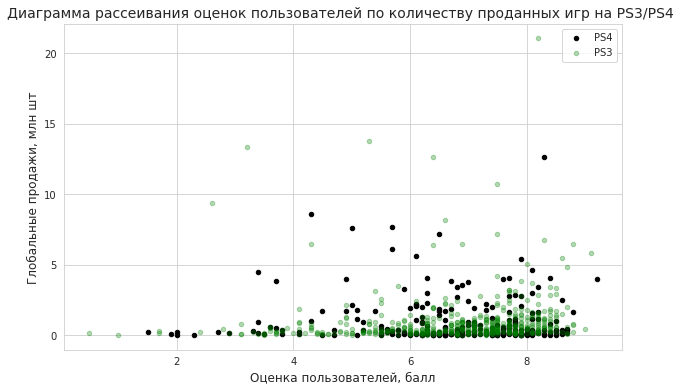

In [64]:
# строим точечную диаграмму для user_score

ax = ps4_data.plot(kind='scatter', x='user_score', y='total_sales', grid=True, color='black', label='PS4')
ps3_data.plot(kind='scatter', x='user_score', y='total_sales', figsize=(10,6), grid=True, ax=ax, alpha=0.3, color='green', 
              label='PS3')
plt.title('Диаграмма рассеивания оценок пользователей по количеству проданных игр на PS3/PS4 ', fontsize=14)
plt.xlabel('Оценка пользователей, балл', fontsize=12)
plt.ylabel('Глобальные продажи, млн шт',fontsize=12)
plt.show()

*Наблюдение_27*  

Для обоих платформ наблюдается общая тенденция: видна более яркая зависимость продаж игр от оценки критиков.

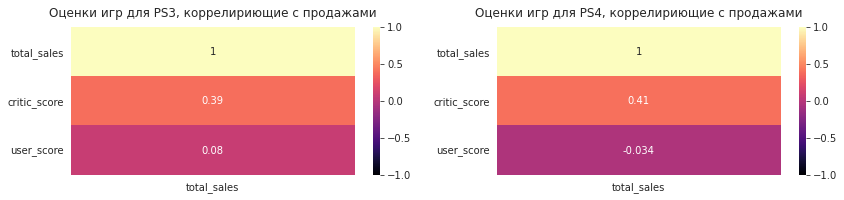

In [65]:
# построим матрицу корреляции длы PS3

score_filter_1 = ps3_data[['total_sales' ,'critic_score', 'user_score']]

fig = plt.figure(figsize=(14, 6))

ax_1 = fig.add_subplot(2, 2, 1)
ax_1 = sns.heatmap(score_filter_1.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_1.set_title('Оценки игр для PS3, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

# построим матрицу корреляции длы PS4

score_filter_2 = ps4_data[['total_sales' ,'critic_score', 'user_score']]

ax_2 = fig.add_subplot(2, 2, 2)
ax_2 = sns.heatmap(score_filter_2.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_2.set_title('Оценки игр для PS4, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

plt.show()

*Наблюдение_28*  

ЧТД. Коэффициент корреляции сильнее связывает продажи и оценки критиков.

#### Анализ для XBox

In [66]:
# создаем df для XOne и X360

xone_data = df_2010[(df_2010['platform'] == 'XOne') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]
x360_data = df_2010[(df_2010['platform'] == 'X360') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]

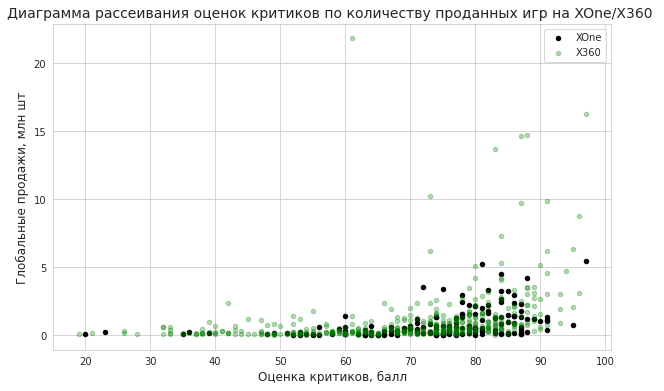

In [67]:
# строим точечную диаграмму для critic_score

ax = xone_data.plot(kind='scatter', x='critic_score', y='total_sales', grid=True, color='black', label='XOne')
x360_data.plot(kind='scatter', x='critic_score', y='total_sales', figsize=(10,6), grid=True, ax=ax, alpha=0.3, color='green', 
               label='X360')
plt.title('Диаграмма рассеивания оценок критиков по количеству проданных игр на XOne/X360 ', fontsize=14)
plt.xlabel('Оценка критиков, балл', fontsize=12)
plt.ylabel('Глобальные продажи, млн шт',fontsize=12)
plt.show()

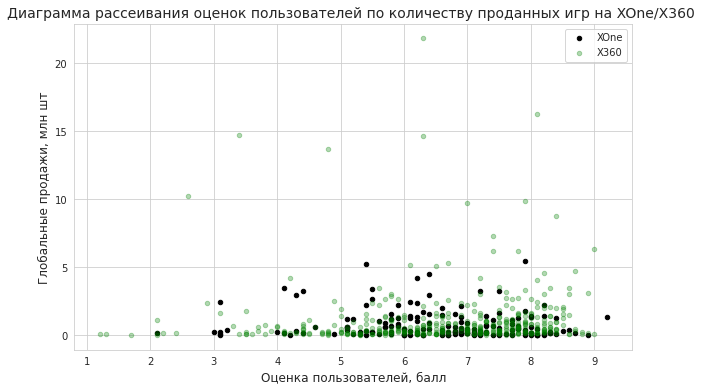

In [68]:
# строим точечную диаграмму для user_score

ax = xone_data.plot(kind='scatter', x='user_score', y='total_sales', grid=True, color='black', label='XOne')
x360_data.plot(kind='scatter', x='user_score', y='total_sales', figsize=(10,6), grid=True, ax=ax, alpha=0.3, color='green', 
               label='X360')
plt.title('Диаграмма рассеивания оценок пользователей по количеству проданных игр на XOne/X360 ', fontsize=14)
plt.xlabel('Оценка пользователей, балл', fontsize=12)
plt.ylabel('Глобальные продажи, млн шт',fontsize=12)
plt.show()

*Наблюдение_29*  

Ситуация такая же как и для PS платформ.

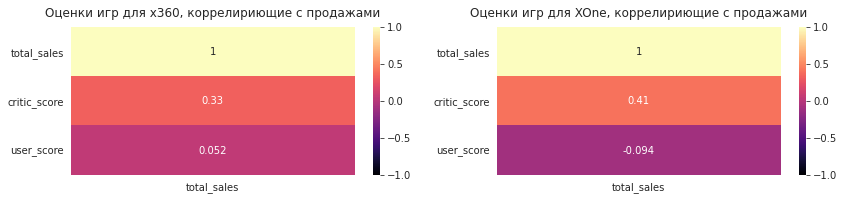

In [69]:
# построим матрицу корреляции длы X360

score_filter_1 = x360_data[['total_sales' ,'critic_score', 'user_score']]

fig = plt.figure(figsize=(14, 6))

ax_1 = fig.add_subplot(2, 2, 1)
ax_1 = sns.heatmap(score_filter_1.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_1.set_title('Оценки игр для x360, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

# построим матрицу корреляции длы XOne

score_filter_2 = xone_data[['total_sales' ,'critic_score', 'user_score']]

ax_2 = fig.add_subplot(2, 2, 2)
ax_2 = sns.heatmap(score_filter_2.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_2.set_title('Оценки игр для XOne, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

plt.show()

*Наблюдение_30*  

Так же видим, что коэффициент корреляции сильнее связывает продажи и оценки критиков.  
Для двух новых платформ видна похожая линия поведения коэф Пирсона - отрицательная. Думаю, это связано с тем, что эти платформы еще не набрали большого круга пользователей.

**Вывод**  
> Оценка критиков сильнее влияет на продоваемость игр  
> Оценка пользователей практически не играет роли для продаж  

### Сравнение предыдущих выводов с продажами игр на других платформах

In [70]:
# построим матрицы корреляции для 'Wii', 'DS', 'WiiU', 'PSP', '3DS', 'PC'

wii_data = df_2010[(df_2010['platform'] == 'Wii') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]
ds_data = df_2010[(df_2010['platform'] == 'DS') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]
wiiu_data = df_2010[(df_2010['platform'] == 'WiiU') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]
psp_data = df_2010[(df_2010['platform'] == 'PSP') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]
ds3_data = df_2010[(df_2010['platform'] == '3DS') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]
pc_data = df_2010[(df_2010['platform'] == 'PC') & (df_2010['critic_score'] > 0) & (df_2010['user_score'] > 0)]                                                                             

In [71]:
# фильтры

score_filter_1 = wii_data[['total_sales' ,'critic_score', 'user_score']]
score_filter_2 = ds_data[['total_sales' ,'critic_score', 'user_score']]
score_filter_3 = wiiu_data[['total_sales' ,'critic_score', 'user_score']]
score_filter_4 = psp_data[['total_sales' ,'critic_score', 'user_score']]
score_filter_5 = ds3_data[['total_sales' ,'critic_score', 'user_score']]
score_filter_6 = pc_data[['total_sales' ,'critic_score', 'user_score']]

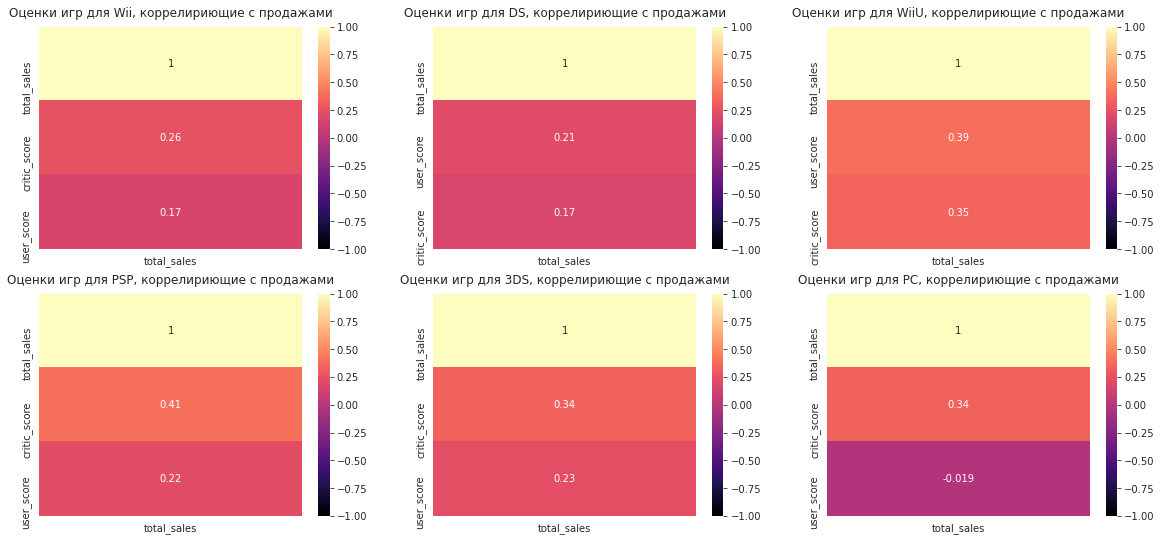

In [72]:
# построим матрицы корреляции 

fig = plt.figure(figsize=(20,9)) 

ax_1 = fig.add_subplot(2, 3, 1)
ax_1 = sns.heatmap(score_filter_1.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_1.set_title('Оценки игр для Wii, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

ax_2 = fig.add_subplot(2, 3, 2)
ax_2 = sns.heatmap(score_filter_2.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_2.set_title('Оценки игр для DS, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

ax_3 = fig.add_subplot(2, 3, 3)
ax_3 = sns.heatmap(score_filter_3.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_3.set_title('Оценки игр для WiiU, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

ax_4 = fig.add_subplot(2, 3, 4)
ax_4 = sns.heatmap(score_filter_4.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_4.set_title('Оценки игр для PSP, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

ax_5 = fig.add_subplot(2, 3, 5)
ax_5 = sns.heatmap(score_filter_5.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_5.set_title('Оценки игр для 3DS, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

ax_6 = fig.add_subplot(2, 3, 6)
ax_6 = sns.heatmap(score_filter_6.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), vmin=-1, vmax=1, 
                   annot=True, cmap='magma')
ax_6.set_title('Оценки игр для PC, коррелириющие с продажами', fontdict={'fontsize':12}, pad=10)

plt.show()

*Наблюдение_31*  

Тенденция сохраняяется: оценка критиков влияет больше на продажи, чем оценка пользователей.  
Для PC зависимость цены от оценки пользователей крайне мала и отрицательная, так как данная платформа уже изживает себя и пользователей мало.  
Для PS4 и XOne коэф. корреляции так же отрицательный, так как оценок еще мало.

**Вывод**  
> Оценка критиков сильнее влияет на продоваемость игр  
> Оценка пользователей практически не играет роли для продаж  

### Анализ общего распределения игр по жанрам

Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [73]:
# посмотрим сколько жанров всего

df_2010['genre'].unique()

array(['Misc', 'Action', 'Role-Playing', 'Shooter', 'Racing', 'Platform',
       'Simulation', 'Sports', 'Fighting', 'Strategy', 'Adventure',
       'Puzzle'], dtype=object)

In [74]:
# посмотрим на распределения жанров по количеству выпущенных игр

df_genre = df_2010.groupby(['genre'])['genre'].count()
df_genre = df_genre.sort_values(ascending=False)
#df_genre

In [75]:
# посмотрим на распределение продаж по жанрам

df_genre_sum = df_2010.groupby(['genre'])['total_sales'].sum()
df_genre_sum = df_genre_sum.sort_values(ascending=False)
#df_genre_sum

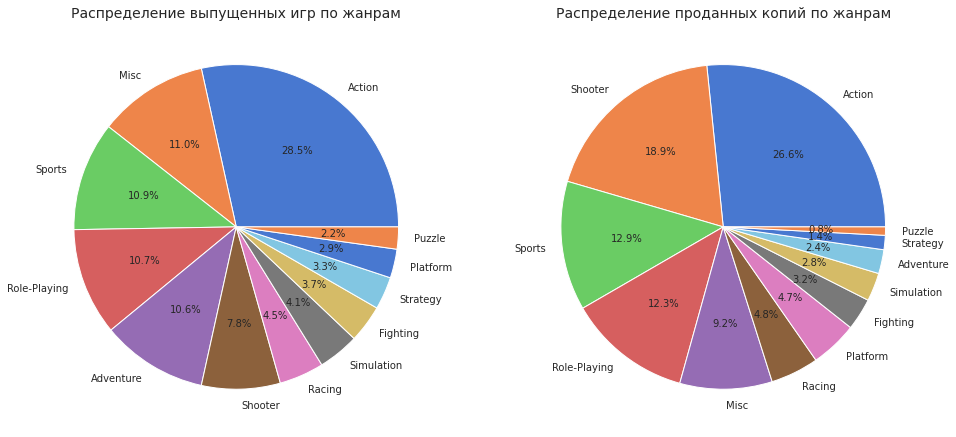

In [76]:
#  строим две круговые диаграммы

genre_name = df_genre.index
fig = plt.figure(figsize=(16, 32))
ax_1 = fig.add_subplot(2, 2, 1)
ax_1 = plt.pie(df_genre, labels=genre_name, autopct='%1.1f%%')
ax_1 = plt.title("Распределение выпущенных игр по жанрам", fontsize=14)

genre_name = df_genre_sum.index
ax_2 = fig.add_subplot(2, 2, 2)
ax_2 = plt.pie(df_genre_sum, labels=genre_name, autopct='%1.1f%%')
ax_2 = plt.title("Распределение проданных копий по жанрам", fontsize=14)

plt.show()

*Наблюдение_32*  

Самый популярный жанр по продажам и производству - Экшен, самый непопулярный жанр - Puzzle.  
~~Второе место по производству и популярности - Sports, третье место по продажам - Shooter, а вот по производству - Misc (Miscellaneous game)~~. Второе место по производству занимает Misc (Miscellaneous game), по популярности - Shooter.  
Третье место по продажам и производству - Sports.  
~~Интересно, что шутеров производят много, а продается почти в два раза меньше~~. Интересная ситуация с  Adventure: производят 10,6% от всех игр, а продают всего 2,4% (разница в 4.5 раза!). Картина немного поменялась - Shooter игр производят мало, а продают много. Это может говорить о любви игроков к этому жанру и сложности его воплощения в игре. 

**Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**  
> Самые ~~продоваемые*~~ популярные игры: Action, Shooter, Sports   
> Самая непопулярные игры: Strategy, Puzzle, Adventure  

'*' Я не уверена, что можно именно говорить про прибыль, потому что я не знаю цены на игры. А сравнивать Puzzle и Action по затратам времени и ресурсов на производство этих игр вообще не стоит.  

In [77]:
df_genre_sales = df_2010.groupby(['genre'])['total_sales'].agg(['mean', 'median']).reset_index()
df_genre_sales = df_genre_sales.sort_values(by='median', ascending=False)
df_genre_sales

,genre,mean,median
8,Shooter,1.156403,0.38
4,Platform,0.782484,0.21
10,Sports,0.569948,0.20
2,Fighting,0.410000,0.18
6,Racing,0.517637,0.17
0,Action,0.449590,0.15
7,Role-Playing,0.554183,0.15
3,Misc,0.403173,0.13
9,Simulation,0.330505,0.10
11,Strategy,0.210173,0.08


*Наблюдение_32_1*  

Наиболее прибыльный жанр - Shooter (хотя его и выпускают в малых тирожах и производство, наверняка, дорого стоит. Наверное, каждый раз неплохо так выстреливают такие игры).  
На втором месте (что меня удивило) - игры Platform. По идее, на их создание не нужно больших ресурсов, они не оч популярны и их мало производят. Возможно, им очень накручивают цену и такие игры в основном популярны у детей.  
Третье место - Sports. Ну тут ничего необычного - жанр интересный, сложный для воплощения и заставляет людей испытывать яркие эмоции (плюс хорош в компании).   
Немного стало грустно за Action, так как он вроде и продается/производится в больших объёмах, а выхлоп не такой впечатляющий. Наверное, такие игры достаточно сложны в прохождении. Плюс, согласно <a href="https://ru.wikipedia.org/wiki/Action#:~:text=%D0%AD%D0%BA%D1%88%D0%B5%D0%BD%20(action%20%D0%B2%20%D0%BF%D0%B5%D1%80%D0%B5%D0%B2%D0%BE%D0%B4%D0%B5%20%D1%81,%D0%B8%20%D1%80%D1%83%D0%BA%20%D0%B8%20%D1%81%D0%BA%D0%BE%D1%80%D0%BE%D1%81%D1%82%D0%B8%20%D1%80%D0%B5%D0%B0%D0%BA%D1%86%D0%B8%D0%B8.">Википедии</a>, жанры Shooter(!), Fighting и Platformer(!) являются потомками жанра Action. Возможно, поджанры стали людям заходить больше.

**Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**  
> Самые продоваемые игры: Shooter, Platfrom, Sports   
> Самая низкодоходные игры: Strategy, Puzzle, Adventure (что совпадает с их "популярностью")  

### Вывод

1) Количество игр (выпущенных и проданных) начало активно расти в 90х годах по 2008 год. С 2009 начался спад продаж и уменьшение количества релизов за счет развития портативной цифровизации - первый Iphone  и тд  
2) Наиболее продаваемые игры в этот период были на следующие консоли: PS2, X360, PS3, Wii, DS, PS    
3) Средняя продолжительность "жизни" консоли - 10 лет, пик продаж в среднем наступает через 4 года, новая консоль выходит спустя год/два по достижению пика продаж - в течении этого года (двух) идет снижение продаж   
4) Наиболее популярные платформы в период с ~~2005~~ 2010 - 2016 года: ~~X360, PS3, Wii~~ PS3, X360, PS4      
5) Лидируют по продажам на конец 2016 года: PS4, XOne, 3DS ( следующии поколения X360, PS3, Wii)     
6) К концу 2016 года PlayStation перехватило лидерство у XBox  
7) Продажи консольных игр падают  
8) Самый маленький спрос на игры для ~~PC~~ PSP и DS    
9) У анализируемых консолей наблюдается связь между продажами и оценкой критиков: чем выше оценка критиков, тем вероятнее игра будет лучше продаваться   
10) Самые продоваемые игры: Shooter, Platfrom, Sports  
11) Самая непопулярные игры: Strategy, Puzzle, Adventure


## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP)

Опишите различия в долях продаж.

In [78]:
# вспомни как выглядит таблица

platf_top_10.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27


In [79]:
# сумма проданных копий для Северной Америки по платформам

na_platf = platf_top_10.groupby(['platform'])['na_sales'].agg(['sum'])

# сумма проданных копий для Европы по платформам

eu_platf = platf_top_10.groupby(['platform'])['eu_sales'].agg(['sum'])

# сумма проданных копий для Японии по платформам

jp_platf = platf_top_10.groupby(['platform'])['jp_sales'].agg(['sum'])

In [80]:
# объединяем Series

users_platf = pd.concat([na_platf, eu_platf, jp_platf], axis=1).reset_index()
users_platf.columns = ['platform', 'american_user', 'europe_user', 'japan_user']
users_platf = users_platf.sort_values(by='american_user', ascending=False)

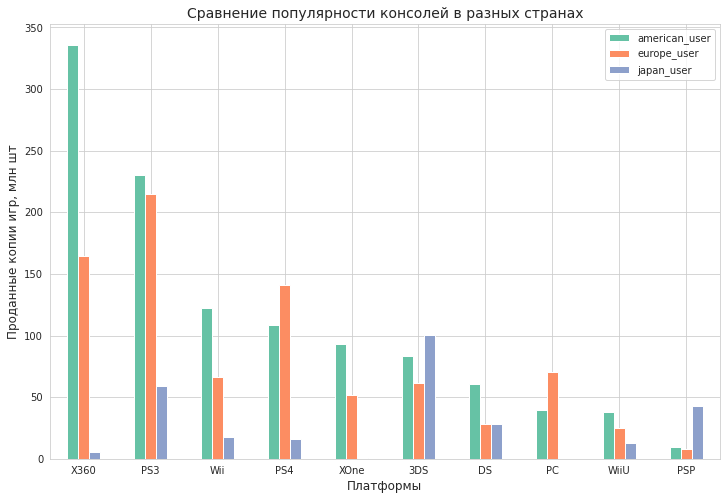

In [81]:
# строим bar plot

sns.set_palette("Set2")
users_platf.plot.bar(x="platform", rot=0, figsize =(12, 8))
plt.title('Сравнение популярности консолей в разных странах', fontsize=14)
plt.xlabel('Платформы', fontsize=12)
plt.ylabel('Проданные копии игр, млн шт',fontsize=12)
plt.show()

*Наблюдение_33*  

В Японии прослеживается популярность местных консолей. В Америке и Европе видим выбор в сторону PS и XBox консолей.

**Самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP)**  
> American user: X360, PS3, Wii, PS4, XOne    
> European user: PS3, PS4, X360, PC, Wii  
> Japanese user: 3DS, PS3, PSP, DS, Wii

### Самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP) 

Поясните разницу.


In [82]:
# сумма проданных копий для Северной Америки по жанрам

na_platf = platf_top_10.groupby(['genre'])['na_sales'].agg(['sum'])

# сумма проданных копий для Европы по жанрам

eu_platf = platf_top_10.groupby(['genre'])['eu_sales'].agg(['sum'])

# сумма проданных копий для Японии по жанрам

jp_platf = platf_top_10.groupby(['genre'])['jp_sales'].agg(['sum'])

In [83]:
# объединяем Series

users_genre = pd.concat([na_platf, eu_platf, jp_platf], axis=1).reset_index()
users_genre.columns = ['genre', 'american_user', 'europe_user', 'japan_user']
users_genre = users_genre.sort_values(by='american_user', ascending=False)

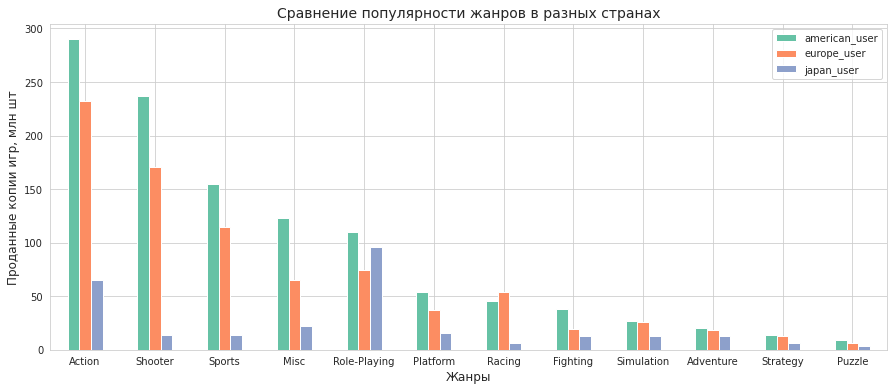

In [84]:
# строим bar plot

users_genre.plot.bar(x="genre", rot=0, figsize =(15, 6))
plt.title('Сравнение популярности жанров в разных странах', fontsize=14)
plt.xlabel('Жанры', fontsize=12)
plt.ylabel('Проданные копии игр, млн шт',fontsize=12)
plt.show()

*Наблюдение_34*  

Для европейци и американца выбор игр почти одинаковый, для японцев же  мы видим немного другую картину. Могу это связять с тем, что на разных консолях преобладают разные жанры.

**Самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP)**  
> American user: ~~Action, Sports, Shooter, Misc, Role-Playing~~ Action, Shooter, Sports, Misc, Role-Playing   
> European user: ~~Action, Sports, Shooter, Misc, Racing~~ Action, Shooter, Sports, Role-Playing, Misc     
> Japanese user: Role-Playing, Action, Misc, Sports, Platform

In [85]:
# проверим мою гипотезу
# посмотрим распределение жанров по двум консолям за все время

# X360 

df_genre_ps = df.query('platform == "X360"')
df_genre_ps = df_genre_ps.groupby('genre')['genre'].count()
df_genre_ps = df_genre_ps.sort_values(ascending=False)

# 3DS

df_genre_ds = df.query('platform == "3DS"')
df_genre_ds = df_genre_ds.groupby('genre')['genre'].count()
df_genre_ds = df_genre_ds.sort_values(ascending=False)

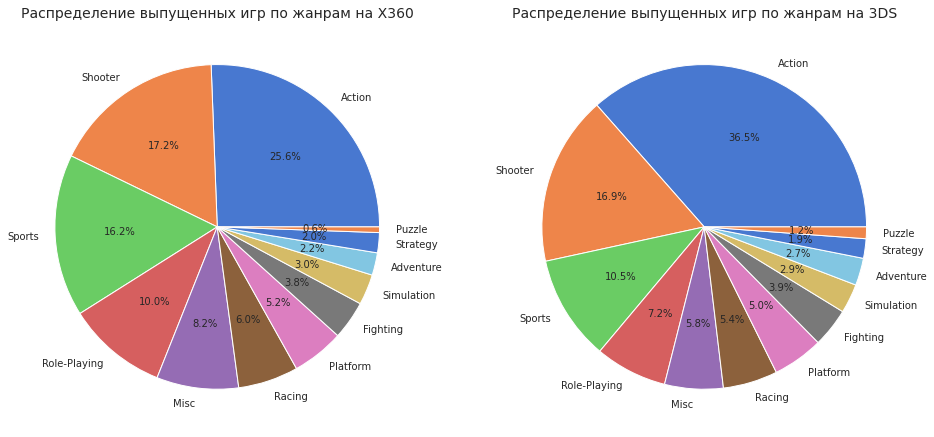

In [86]:
# строим pie plots

sns.set_palette("muted")
genre_name = df_genre_sum.index

fig = plt.figure(figsize=(16, 32))
ax_1 = fig.add_subplot(2, 2, 1)
ax_1 = plt.pie(df_genre_ps, autopct='%1.1f%%', labels=genre_name)
ax_1 = plt.title("Распределение выпущенных игр по жанрам на X360", fontsize=14)

ax_2 = fig.add_subplot(2, 2, 2)
ax_2 = plt.pie(df_genre_ds, autopct='%1.1f%%', labels=genre_name)
ax_2 = plt.title("Распределение выпущенных игр по жанрам на 3DS", fontsize=14)
plt.show()

*Наблюдение_35*  

Видим, что распределение жанров по консолям и правда немного меняется. 

### Исследование влияния рейтинга ESRB на продажи для пользователя каждого региона (NA, EU, JP)

In [87]:
# сумма проданных копий для Северной Америки по рейтингу

na_platf = df_2010.groupby(['rating'])['na_sales'].agg(['sum'])

# сумма проданных копий для Европы по рейтингу

eu_platf = df_2010.groupby(['rating'])['eu_sales'].agg(['sum'])

# сумма проданных копий для Японии по рейтингу

jp_platf = df_2010.groupby(['rating'])['jp_sales'].agg(['sum'])

In [88]:
# объединяем Series 

users_rat = pd.concat([na_platf, eu_platf, jp_platf], axis=1).reset_index()
users_rat.columns = ['rating', 'american_user', 'europe_user', 'japan_user']
users_rat = users_rat.sort_values(by='american_user', ascending=False)
users_rat 

,rating,american_user,europe_user,japan_user
3,M,384.23,294.29,30.47
0,E,272.46,197.62,47.87
1,E10+,161.61,101.16,13.22
5,T,161.21,113.29,42.14
4,RP,156.34,139.56,171.79
2,EC,1.13,0.00,0.00


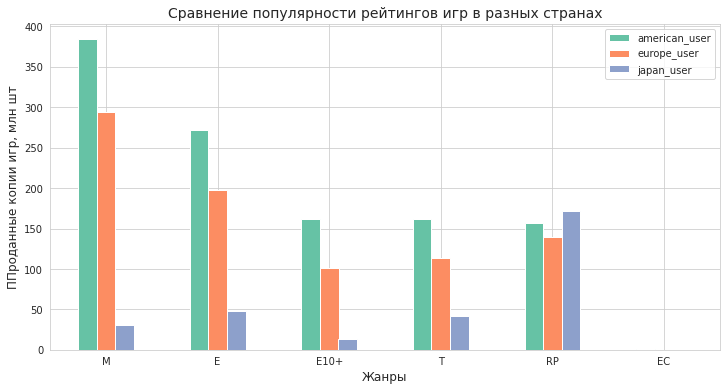

In [89]:
# строим график

sns.set_palette("Set2")
users_rat.plot.bar(x="rating", rot=0, figsize =(12, 6))
plt.title('Сравнение популярности рейтингов игр в разных странах', fontsize=14)
plt.xlabel('Жанры', fontsize=12)
plt.ylabel('ППроданные копии игр, млн шт',fontsize=12)
plt.show()

Описание:

- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»  
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»  
- «M» («Mature») — «Для взрослых»  
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «AO» («Adults Only») — «18+»

*Наблюдение_36*  

Для Японии большинство игр с рейтингом RP, так как ESBR Северно-Американская компания и оценить игры рынка Японии, думаю, не всегда есть возможность.  
Игры для младшего возраста ~~и 18+~~ вообще мало катируются. В Японии и Европе вообще таких игр нет. Думаю, это связано с менталитетом (в Японии) + для такого возраста ~~и целей,~~ сложно придумать игры (особенно когда есть куча книг/видео на других ресурсах).

**Рейтинги (топ-3) для пользователя каждого региона (NA, EU, JP)**  
> American user: ~~E, M, T~~ M, E, T   
> European user: ~~E, M, T~~ M, E, (PR), T   
> Japanese user: (RP), E, T, М

### Вывод

- Американцы предпочитают игры на X360, Wii, PS3 в жанре Action, Sports, Shooter и рейтингом E, M, T  
- Европейцы предпочитают игры на PS3, X360, ~~Wii~~ PS4 в жанре Action, Sports, Shooter и рейтингом E, M, T
- Японцы предпочитают игры на ~~DS~~ PSP, 3DS, PS3 в жанре Role-Playing, Action, Misc и рейтингом (RP), E, T, M

Такое поведение связано с близостью стран Америки и Европы, а вот Япония со своими обычаями отличается вкусами от американцев\европейцев.  
Так же видим, что большинство игр выпускаются с одинаковым рейтингом.  

## Проверка гипотез

### Гипотеза I: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Задайте самостоятельно пороговое значение alpha.  
Поясните:  
Как вы сформулировали нулевую и альтернативную гипотезы;  
Какой критерий применили для проверки гипотез и почему.  

Нулева гипотеза по правилам формируется со знаком равентсва. Тогда:

**H_0 (нулевая гипотеза)** - средние пользовательские рейтинги платформ Xbox One и PC равны   
**H1 (альтернативная гипотеза)** - средние пользовательские рейтинги платформ Xbox One и PC не равны  

**Критический уровень статистической значимости (p_value) будет 0.05.**

1) проверим, что распределение нормальное (Гауссовское) - scipy.stats.normaltest  
2) проверим гипотезу (гауссовское распределение - scipy.stats.ttest_ind (независимые выборки), не гауссовское - scipy.stats.ks_2samp)  

In [90]:
# посмотрим, какой год был, когда user_score первый раз появился

data_user_score = df.query('user_score > 0')
data_user_score['year_of_release'].min()

1985

In [91]:
# создаем выборку по df от 1985

data_1985 = df.query('year_of_release >= 1985')
data_user = data_1985.query('user_score > 0')
df_pc_xbox = data_user.query('platform == "PC" or platform == "XOne"')

pc_data = data_user.query('platform == "PC"')['user_score']
xone_data = data_user.query('platform == "XOne"')['user_score']

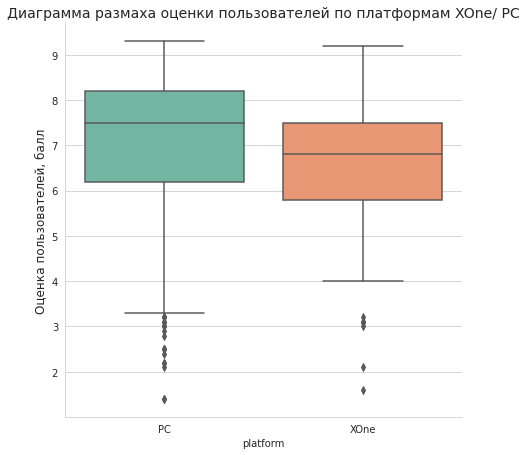

In [92]:
# cначала построим диаграммы размаха для анализа выбросов

sns.catplot(x='platform', y="user_score", kind="box", data=df_pc_xbox, height=6)
plt.ylabel('Оценка пользователей, балл', fontsize=12)
plt.title("Диаграмма размаха оценки пользователей по платформам XOne/ PC", fontsize=14)
plt.show()

*Наблюдение_37*

Распредления не похожи на равные

In [93]:
# посмотрим на разброс и стандартное отклонение

pc_data.describe()

count    766.000000
mean       7.067363
std        1.528032
min        1.400000
25%        6.200000
50%        7.500000
75%        8.200000
max        9.300000
Name: user_score, dtype: float64

In [94]:
# посмотрим на разброс и стандартное отклонение

xone_data.describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

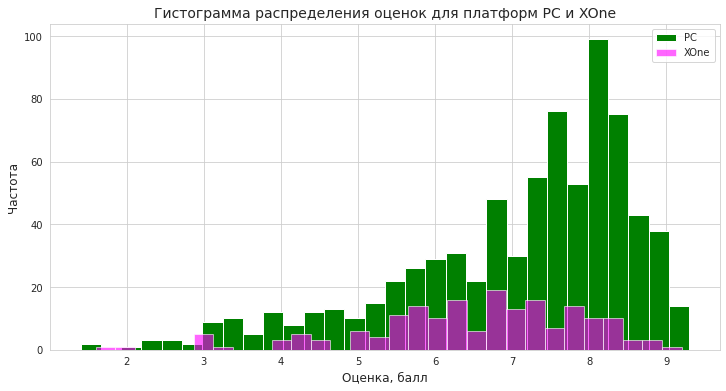

In [95]:
# выведем гистрогамму

ax = pc_data.plot(kind = 'hist', bins = 30, figsize = (12,6), grid=True, rot=0, label='PC', color='green')
xone_data.plot(kind = 'hist', bins = 30, figsize = (12,6), grid=True, rot=0, ax=ax, color='magenta', alpha=0.6, label='XOne')
ax.legend()
plt.title("Гистограмма распределения оценок для платформ PC и XOne", fontsize=14)
plt.xlabel("Оценка, балл", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.show()

*Наблюдение_38*

Распределение для PC похоже на распределение экстремумов (распределение минимального значения), для XOne похоже на нормальное.  
https://habr.com/ru/post/331060/  
https://blog.kinetica.su/osnovy_statistiki_dlya_veb-analitika_15_tipov_raspredeleniya_veroyatnostej/  
http://www.mathtask.ru/0032-principal-laws-of-distribution.php  
https://docs.exponenta.ru/stats/extreme-value-distribution.html

In [96]:
# проверка распределения выборки pc_data на нормальность 
# H_0 - распределение нормальное

value, p = normaltest(pc_data.values)
print(value, p)

if p <= 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

120.51670046687327 6.762869467310339e-27
Отвергаем нулевую гипотезу


In [97]:
# проверка распределения выборки xone_data на нормальность 
# H_0 - распределение нормальное

value, p = normaltest(xone_data.values)
print(value, p)

if p <= 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

22.74026027667708 1.1534936880652902e-05
Отвергаем нулевую гипотезу


Так как вероятность того, что выборки имеют не нормальное распределение больше 95%, сначала испольлуем p_value с помощью теста Колмогорова-Смирнова, а потом просчитаем p_value с пломощью t-теста Уэлча (модифицированный t-критерий Стьюдента)

In [98]:
# тест Колмогорова-Смирнова

print(f'cредняя оценка PC: {round(pd.Series(pc_data).mean(), 2)}')
print(f'cредняя оценка XOne: {round(pd.Series(xone_data).mean(), 2)}')
alpha = .05

results = ks_2samp(pc_data, xone_data)

print('p_value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредняя оценка PC: 7.07
cредняя оценка XOne: 6.52
p_value: 2.591336173460452e-09
Отвергаем нулевую гипотезу


In [99]:
print(f"Дисперсия для PC {np.var(pc_data)}")
print(f"Дисперсия для XOne {np.var(xone_data)}")

Дисперсия для PC 2.3318329936123363
Дисперсия для XOne 1.8965188383045526


In [100]:
# t-тест Уэлча

print(f'cредняя оценка PC: {round(pd.Series(pc_data).mean(), 2)}')
print(f'cредняя оценка XOne: {round(pd.Series(xone_data).mean(), 2)}')
alpha = .05

results = st.ttest_ind(pc_data, xone_data, equal_var = False) # False, так как дисперсии отличаются

print('p_value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредняя оценка PC: 7.07
cредняя оценка XOne: 6.52
p_value: 4.101854214173904e-06
Отвергаем нулевую гипотезу


#### Вывод по гипотезе I

Гипотеза не потвердилась: средние оценки пользователей различаются для PC и XOne.  
Думаю, это связано с тем, что оценок у игр XOne мало, так как платформа еще достаточно молодая.

### Гипотеза II: Средние пользовательские рейтинги жанров Action и Sports  разные

Action (англ. «действие», экшен- игры)/ Sports (англ. «спортивные соревнования»)

Задайте самостоятельно пороговое значение alpha.  
Поясните:  
Как вы сформулировали нулевую и альтернативную гипотезы;  
Какой критерий применили для проверки гипотез и почему.  

**H_0 (нулевая гипотеза)** - cредние пользовательские рейтинги жанров Action и Sports равны  
**H1 (альтернативная гипотеза)** - cредние пользовательские рейтинги жанров Action и Sports не равны   

**Критический уровень статистической значимости (p_value) будет 0.05.**

1) проверим, что распределение нормальное (Гауссовское) - scipy.stats.normaltest  
2) проверим гипотезу (гауссовское распределение - scipy.stats.ttest_ind (независимые выборки), не гауссовское - scipy.stats.ks_2samp)  

In [101]:
# создаем выборку

data_user = data_1985.query('user_score > 0')
act_sport_genre = data_user.query('genre == "Action" or genre == "Sports"')

act_data = data_user.query('genre == "Action"')['user_score']
sport_data = data_user.query('genre == "Sports"')['user_score']

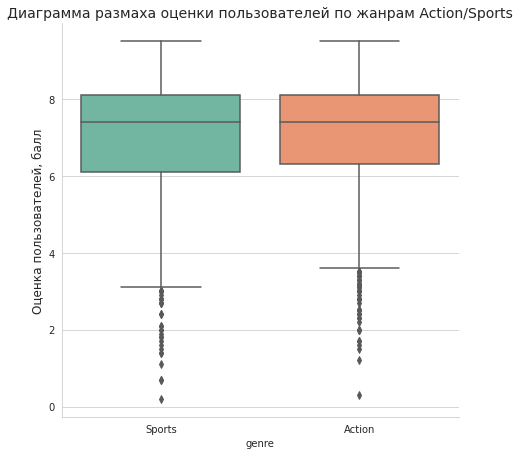

In [102]:
# cначала построим диаграммы размаха для анализа выбросов

sns.catplot(x='genre', y="user_score", kind="box", data=act_sport_genre, height=6)
plt.ylabel('Оценка пользователей, балл', fontsize=12)
plt.title("Диаграмма размаха оценки пользователей по жанрам Action/Sports", fontsize=14)
plt.show()

*Наблюдение_39*

Распредления похожи

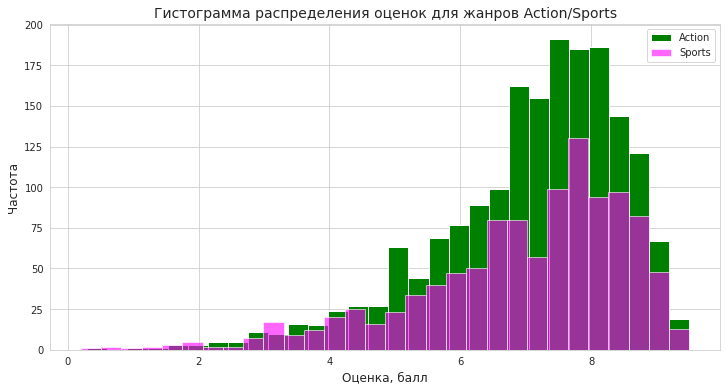

In [103]:
# выведем гистрогамму 

ax = act_data.plot(kind = 'hist', bins = 30, figsize = (12,6), grid=True, rot=0, label='Action', color='green')
sport_data.plot(kind = 'hist', bins = 30, figsize = (12,6), grid=True, rot=0, ax=ax, color='magenta', alpha=0.6, label='Sports')
ax.legend()
plt.title("Гистограмма распределения оценок для жанров Action/Sports", fontsize=14)
plt.xlabel("Оценка, балл", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.show()

*Наблюдение_40*

Оба распредления похожи на распределение экстремумов (распределение минимального значения). 

In [104]:
# посмотрим на разброс и стандартное отклонение

act_data.describe()

count    1820.000000
mean        7.056484
std         1.422936
min         0.300000
25%         6.300000
50%         7.400000
75%         8.100000
max         9.500000
Name: user_score, dtype: float64

In [105]:
# посмотрим на разброс и стандартное отклонение

sport_data.describe()

count    1098.000000
mean        6.956375
std         1.612836
min         0.200000
25%         6.100000
50%         7.400000
75%         8.100000
max         9.500000
Name: user_score, dtype: float64

In [106]:
# проверка распределения выборки act_data на нормальность 
# H_0 - распределение нормальное

value, p = normaltest(act_data.values)
print(value, p)

if p <= 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

301.0507858766159 4.242799026913393e-66
Отвергаем нулевую гипотезу


In [107]:
# проверка распределения выборки sport_data на нормальность 
# H_0 - распределение нормальное

value, p = normaltest(sport_data.values)
print(value, p)

if p <= 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

183.44388245618836 1.4644247330516454e-40
Отвергаем нулевую гипотезу


In [108]:
# тест Колмогорова-Смирнова

print(f'cредняя оценка Action: {round(pd.Series(act_data).mean(), 2)}')
print(f'cредняя оценка Sports: {round(pd.Series(sport_data).mean(), 2)}')
alpha = .05

results = ks_2samp(act_data, sport_data)

print('p_value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредняя оценка Action: 7.06
cредняя оценка Sports: 6.96
p_value: 0.16002451596955708
Не получилось отвергнуть нулевую гипотезу


In [109]:
print(f"Дисперсия для action {np.var(act_data)}")
print(f"Дисперсия для sports {np.var(sport_data)}")

Дисперсия для action 2.0236337881898323
Дисперсия для sports 2.5988710140311415


In [110]:
# t-тест Уэлча

print(f'cредняя оценка Action: {round(pd.Series(act_data).mean(), 2)}')
print(f'cредняя оценка Sports: {round(pd.Series(sport_data).mean(), 2)}')
alpha = .05

results = st.ttest_ind(act_data, sport_data, equal_var = False) # False, так как дисперсии отличаются, но совсем немного

print('p_value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредняя оценка Action: 7.06
cредняя оценка Sports: 6.96
p_value: 0.08991887133875968
Не получилось отвергнуть нулевую гипотезу


#### Вывод по гипотезе II

Гипотеза про разность оценок для двух жанров не подтверилась: средние оценки пользователей игр жанров Action и Sports одинаковые.  
Мы и до этого видели, что эти два жанра самые любимые у пользователей, что может говорить о похожести средних оценок.

## Общий вывод
 
1) Количество игр (выпущенных и проданных) начало активно расти в 90х годах по 2008 год. С 2009 начался спад продаж и уменьшение количества релизов за счет развития портативной цифровизации - первый Iphone  и тд  
2) Наиболее продаваемые игры в этот период были на следующие консоли: PS2, X360, PS3, Wii, DS, PS  
3) Средняя продолжительность "жизни" консоли - 10 лет, пик продаж в среднем наступает через 4 года, новая консоль выходит спустя в среднем 5 лет (по достижению пика и последующему снижению продаж)  
4) Наиболее популярные платформы в период с 2010 - 2016 года: PS3, X360, PS4  
5) Лидируют по продажам на конец 2016 года: PS4, XOne, 3DS ( следующии поколения X360, PS3, Wii)  
6) К концу 2016 года PlayStation перехватило лидерство у XBox  
7) Продажи консольных игр падают  
8) Самый маленький спрос на игры для PSP и DS  
9) У анализируемых консолей наблюдается связь между продажами и оценкой критиков: чем выше оценка критиков, тем вероятнее игра будет лучше продаваться  
10) Самые продоваемые жанры игр: Shooter, Platfrom, Sports    
11) Самые непопулярные игры: Strategy, Puzzle, Adventure  
12) Американцы предпочитают игры на X360, Wii, PS3 в жанре Action, Sports, Shooter и рейтингом E, M, T  
13) Европейцы предпочитают игры на PS3, X360, PS4 в жанре Action, Sports, Shooter и рейтингом E, M, T  
14) Японцы предпочитают игры на PSP, 3DS, PS3 в жанре Role-Playing, Action, Misc и рейтингом (RP), E, T, M   

**Выявим определяющие успешность игры закономерности**  
> игра выпущена на консоль, которой до 5 лет и она еще не достигла пика продаж  
> игра для одной из популярных платформ: PS, Xbox, Nintendo   
> игра в жанре Shooter, Platfrom или Sports  
> рейтинг игры E, M, T  
> критики высокого оценили игру  
> игра ориентируются на пользователя каждой отдельной страны/региона